In [1]:
from pprint import pprint

import shap
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Data

In [2]:
# Cargamos nuestros datasets
# Aquí nos preocupamos por traer nuestro "final_dataset" el cual fue creado
# mediante el proceso de Feature Engineering
# "labels" se refiere a la variable "cost_of_living"
dataset = pd.read_csv('../final_dataset.csv.gz', compression='gzip')
labels = pd.read_csv('../labels.csv.gz', compression='gzip')
dataset = pd.merge(dataset, labels, how='left', left_on='hex_id', right_on='hex_id')
dataset = dataset.set_index('hex_id').astype('float')

# Separamos nuestro train y test set
train = dataset[~dataset.cost_of_living.isna()]
test = dataset[dataset.cost_of_living.isna()]

# Separamos las variables dependientes (y) de las independientes (X)
X_train = train[[c for c in train if c != 'cost_of_living']].values
X_test = test[[c for c in test if c != 'cost_of_living']].values
y_train = train[['cost_of_living']].values.reshape(len(train), -1)
y_test = test[['cost_of_living']].values.reshape(len(test), -1)

In [3]:
# Pipeline base
model = Pipeline([
    ('regressor', XGBRegressor())
])

# Parámetros expandidos
param_dist = {
    # Parámetros básicos
    'regressor__n_estimators': [50, 100, 200, 300, 500],      # Cuántos árboles
    'regressor__max_depth': [3, 4, 5, 6, 7, 9],               # De qué profundidad deben de ser los árboles
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],  # Cuál es la tasa de aprendizaje
    
    # Regularización
    'regressor__reg_alpha': [0, 0.1, 0.5, 1, 5],              # L1
    'regressor__reg_lambda': [0, 0.1, 1, 5, 10],              # L2
    'regressor__min_child_weight': [1, 3, 5, 7],              # Cuántas observaciones dejaremos por nodo
    
    # Control de columnas/features (es una forma de regularización)
    'regressor__colsample_bytree': [0.3, 0.5, 0.7, 1.0],      # Qué fracción de columnas dejamos en cada árbol
    'regressor__colsample_bylevel': [0.3, 0.5, 0.7, 1.0],     # Qué fracción de columnas dejamos en cada rama
    'regressor__subsample': [0.6, 0.8, 1.0],                  # Qué fracción de registros usamos
    
    # Control de complejidad adicional
    'regressor__gamma': [0, 0.1, 0.2, 0.5],                   # Penalización en la función de costo
    'regressor__max_leaves': [0, 3, 7, 15]                    # Número de hojas/terminaciones dejamos
}

In [4]:
#
# Optimización:
#
# Aqui hacemos validación cruzada, dicho de otro modo,
# para evitar un "sobre-ajuste" (overfitting) escogeremos
# aquellos hiperparámetros que obtengan el error más bajo
# despues de entrenar en K-1 fragmentos del conjunto de entrenamiento.
# Si K=5, usamos 4 fragmentos y evaluamos en el restante. Aquel
# conjunto de hiperparámetros con el error promedio menor será seleccionado.
cv = KFold(n_splits=5, shuffle=True)#, random_state=42)
random_search = RandomizedSearchCV(
    model, param_dist, 
    n_iter=100,
    cv=cv,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_root_mean_squared_error',
    n_jobs=-1  # Usar todos los cores
)

# Entrenamiento y evaluación
random_search.fit(X_train, y_train)

# Resultados
best_params = random_search.best_params_
rmse = -random_search.best_score_
mae = -random_search.cv_results_['mean_test_neg_mean_absolute_error'][random_search.best_index_]

pprint(f'Best parameters: {best_params}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

("Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 5, "
 "'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, "
 "'regressor__min_child_weight': 3, 'regressor__max_leaves': 0, "
 "'regressor__max_depth': 7, 'regressor__learning_rate': 0.01, "
 "'regressor__gamma': 0, 'regressor__colsample_bytree': 0.7, "
 "'regressor__colsample_bylevel': 0.5}")
RMSE: 0.17
MAE: 0.13


# Interpretación de variables

Los _SHAP_ values miden cuánto cada variable contribuye a una predicción individual del modelo, comparando lo que el modelo predice cuando esa variable está presente versus cuando no lo está.

Es como medir la contribución de un jugador en un deporte colectivo, pero considerando ESPECÍFICAMENTE cómo juega en COMBINACIÓN con diferentes compañeros de equipo. Un jugador podría ser excelente cuando juega junto a ciertos compañeros, pero menos efectivo con otros. Los _SHAP values_ miden precisamente estas contribuciones teniendo en cuenta TODAS las posibles combinaciones de jugadores con los que podría coexistir.

Por ejemplo, si predecimos "costo de vida por zona", los SHAP values nos dirían exactamente cuánto "costo" añade o resta cada característica (como la infraestructura o situación del mercado inmobiliario) al costo final estimado; pero, las contribuciones de cada variable toman en cuenta cómo a su vez interactúan con otros predictores.

El gráfico que se muestra a continuación sigue cierta nomenclatura:
* __El orden vertical de las variables importa:__ Aquellas variables que se muestran hasta arriba son las más importantes.
* __El color de los puntos nos indica cuán alto o bajo es el valor de la variable en cuestión:__
  - Cada punto representa una observación
  - Si el color de un punto es <span style='color:dodgerblue; font-weight:800;'>AZUL</span>, significa que el registro tiene un valor <span style='color:dodgerblue; font-weight:800;'>BAJO</span> para la variable analizada.
  - Si el color de un punto es <span style='color:red; font-weight:800;'>ROJO</span>, significa que el registro tiene un valor <span style='color:red; font-weight:800;'>ALTO</span> para la variable analizada.
* __La posición de los puntos con respecto al eje vertical ( <span style='color:gray; font-weight:800;'>|</span> ) importa:__
  - Si un punto se encuentra a la __IZQUIERDA__ significa que ese valor contribuye a que la prediccón del "costo de vida" sea __MENOR__ al promedio.
  - Si un punto se encuentra a la __DERECHA__ significa que ese valor contribuye a que la prediccón del "costo de vida" sea __MAYOR__ al promedio.

Con estos tres criterios, la posición vertical, el color de los puntos y su posición con respecto al eje vertical, podemos interpretar cómo las variables independientes se relacionan con la variable dependiente.

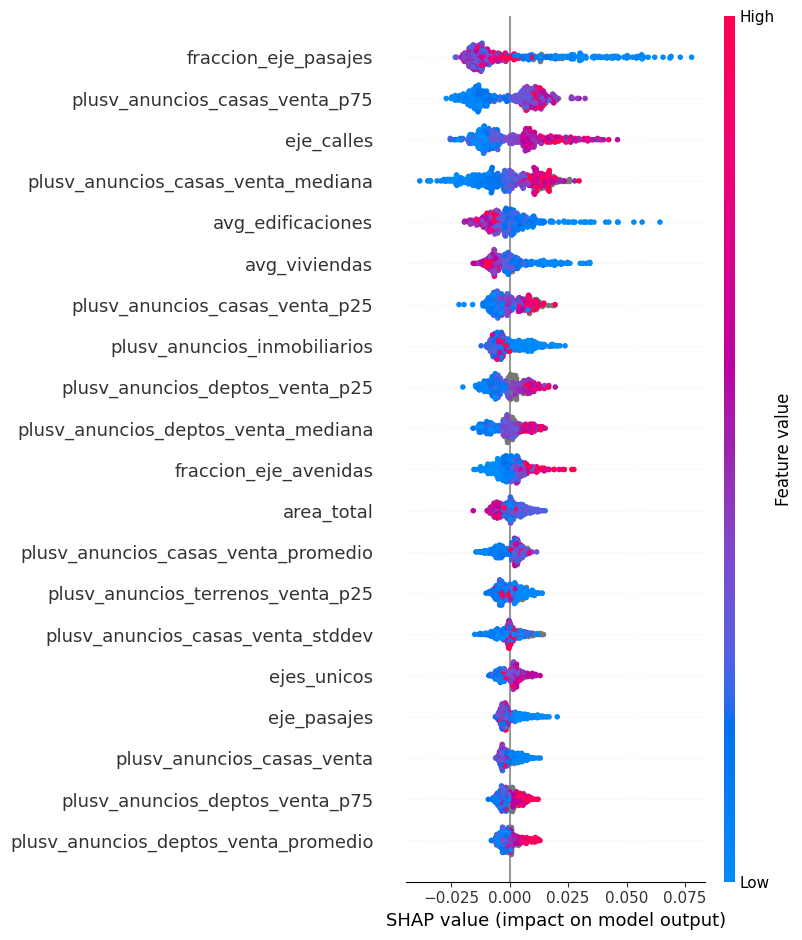

In [5]:
xgb_model = random_search.best_estimator_.named_steps['regressor']
# Calcular SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Crear beeswarm plot
feature_names = [c for c in train if c != 'cost_of_living']
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

__Interpretación:__
1. __`eje_calles`__: A mayor número de calles en una zona, mayor es el costo de vida. Esto puede interpretarse como aquellas zonas en donde hay mayor infraestructura suelen ser zonas más caras (__relación positiva__: a mayor número de calles mayor el costo de vida).
2. __`fraccion_eje_pasajes`__: De todos los ejes en un hexágono dado, qué fracción son "ejes de pasaje". Esto insinúa que si existe una gran proporción de pasajes en una zona el costo de vida suele ser menor. Con esto, podemos entender que las zonas con muchos pasajes no son zonas residenciales de plusvalía sino zonas de tránsito (__relación inversa__: a mayor proporción de pasajes menor el costo de vida).
3. __`plusv_anuncios_casas_venta_p75`__: Dados los anuncios de casas en venta en `plusvalia.com`, la variable indica cuál es el percentil 75 de los precios de los inmuebles ofertados del héxagono en cuestión. Dicho de otro modo, si el 25% de las casas en un hexágono son más caras que el top 25% de otras zonas, podemos asociar un costo de vida más elevado (__relación positiva__: a mayor valor en el P75 del precio de las casas en venta, mayor es el costo de vida).
4. __`plusv_anuncios_casas_venta_mediana`__: Si el precio mediano de las casas en venta para una región es elevado, podemos esperar un costo de vida alto (__relación positiva__: a mayor precio mediano de las casas en venta, mayor el costo de vida).
5. __`avg_viviendas`__: Esta variable se refiere al número promedio de viviendas de las manzanas de cada hexágono. En otras palabras, para construirla se observa qué manzanas existen dentro del hexágono, y se promedia el número de viviendas. Podemos ver que si el valor esperado de las viviendas de las manzanas es alto, menor es el costo de vida. Esto puede insinuar que aquellas zonas con mucha densidad coinciden con zonas con inmuebles de menor tamaño. Asimismo, aquellas zonas urbanas con mucha población concentrada en pocos metros cuadrados se presta a una mayor probabilidad de situación de hacinamiento, mientras que zonas con menos viviendas pueden asociarse con zonas con casas de mayor tamaño, o con zonas con uso de suelo diverso (zonas comerciales, establecimientos, parques, etc).

Etcétera ...